In [3]:
import os
# Change the working directory
os.chdir('/private/home/yxu267/anaconda3/envs/dimelo/lib/python3.10/site-packages')

# Verify the change
print(os.getcwd())


/private/home/yxu267/anaconda3/envs/dimelo/lib/python3.10/site-packages


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import ast



column_names = ['Chromosome', 'Start/End', 'Density', 'Coverage']
# Load the CSV file into a DataFrame
CENPA_chrom_arm_df = pd.read_csv('CENPA_chromosome_arm_random_region_dict_region_density_scores.csv',
                              header=None,
                              names=column_names,
                              sep='\t')

CENPA_CDR_df = pd.read_csv('/private/groups/migalab/dan/data_analysis/mC_border_analysis/CENPA_CDR_dict_region_density_scores.csv',
                           header=None,
                           names=column_names,
                              sep='\t')

CENPA_non_active_df = pd.read_csv('/private/groups/migalab/dan/data_analysis/mC_border_analysis/none_CDR_active_dict_region_density_scores.csv',
                                  header=None,
                                  names=column_names,
                              sep='\t')

#Thes lines remove the X and Y chromosomes 

CENPA_chrom_arm_df = CENPA_chrom_arm_df[~CENPA_chrom_arm_df['Chromosome'].str.contains('chrX_MATERNAL')]
CENPA_chrom_arm_df = CENPA_chrom_arm_df[~CENPA_chrom_arm_df['Chromosome'].str.contains('chrY_PATERNAL')]

CENPA_non_active_df = CENPA_non_active_df[~CENPA_non_active_df['Chromosome'].str.contains('chrX_MATERNAL')]
CENPA_non_active_df = CENPA_non_active_df[~CENPA_non_active_df['Chromosome'].str.contains('chrY_PATERNAL')]

CENPA_CDR_df = CENPA_CDR_df[~CENPA_CDR_df['Chromosome'].str.contains('chrX_MATERNAL')]
CENPA_CDR_df = CENPA_CDR_df[~CENPA_CDR_df['Chromosome'].str.contains('chrY_PATERNAL')]

chromosomes = [f'chr{i}' for i in range(1, 23)]


In [5]:
from Bio import SeqIO
#parse CDR based on A count 


assembly_ = open("/private/groups/migalab/dan/reference/hg002v1.0.1.fasta", "r")

#Load the reference genome and make it into a dictionary 
fasta_sequences = SeqIO.parse(assembly_, "fasta")
assembly={}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    assembly[name] = sequence

#Make a dictionary for all the chromosomes and their corresponding sequence length 
assembly_sequence_length = {}    
for chromosome in assembly:
    assembly_sequence_length[chromosome] = len(assembly[chromosome])
    
assembly_.close()



In [6]:
   
def comprehensive_mA_density_calculation(region_df, assembly):   
    region_weighted_df = pd.DataFrame(columns=['Chromosome', 'Difference', 'Average'])
    region_combined_df = pd.DataFrame(columns=['Chromosome', 'Start/End', 'Density'])

    # Filter rows for chromosome 1 to 22
    chromosomes = [f'chr{i}' for i in range(1, 23)]

    for chrom in chromosomes:

        maternal_col = f'{chrom}_MATERNAL'
        paternal_col = f'{chrom}_PATERNAL'

        #grab chromosome hap coordinates and put them in seperate lists 
        MAT_indices = region_df.index[region_df['Chromosome'] == maternal_col].tolist()
        PAT_indices = region_df.index[region_df['Chromosome'] == paternal_col].tolist()

        #make the start and end positions of each and every chromosome into and individual list 
        PAT_CDR_coordinates_from_density = region_df.loc[PAT_indices]['Start/End'].tolist()
        MAT_CDR_coordinates_from_density = region_df.loc[MAT_indices]['Start/End'].tolist()
        
        PAT_CDR_coordinates_total_A = 0 
        PAT_CDR_coordinates_total_mA = 0 

        # calculate the total amount of mA from the total amount of As in the reference genome and density 
        # calculated in the previous script in both Paternal and Maternal chromosomes 
        for coordinate in range (len(PAT_CDR_coordinates_from_density)): 
            PAT_CDR_coordinates_start_end = ast.literal_eval(PAT_CDR_coordinates_from_density[coordinate])
            PAT_CDR_coordinates_start = int (PAT_CDR_coordinates_start_end[0])
            PAT_CDR_coordinates_end = int (PAT_CDR_coordinates_start_end[1])
            PAT_CDR_A_count = assembly[paternal_col][PAT_CDR_coordinates_start:PAT_CDR_coordinates_end].count('A')
            PAT_CDR_coordinates_total_A += PAT_CDR_A_count
            PAT_CDR_coordinates_total_mA += PAT_CDR_A_count * region_df['Density'][PAT_indices[coordinate]]


        PAT_CDR_coordinates_comprehensive_density = PAT_CDR_coordinates_total_mA / PAT_CDR_coordinates_total_A
        new_row = pd.DataFrame({
                                    'Chromosome': [paternal_col],
                                    'Start/End': [[PAT_CDR_coordinates_start, PAT_CDR_coordinates_end]],
                                    'Density': [PAT_CDR_coordinates_comprehensive_density]
                                })

        region_combined_df = pd.concat([region_combined_df, new_row], ignore_index=True)


        MAT_CDR_coordinates_total_A = 0 
        MAT_CDR_coordinates_total_mA = 0 

        for coordinate in range (len(MAT_CDR_coordinates_from_density)): 
            MAT_CDR_coordinates_start_end = ast.literal_eval(MAT_CDR_coordinates_from_density[coordinate])
            MAT_CDR_coordinates_start = int (MAT_CDR_coordinates_start_end[0])
            MAT_CDR_coordinates_end = int (MAT_CDR_coordinates_start_end[1])
            MAT_CDR_A_count = assembly[maternal_col][MAT_CDR_coordinates_start:MAT_CDR_coordinates_end].count('A')
            MAT_CDR_coordinates_total_A += MAT_CDR_A_count
            MAT_CDR_coordinates_total_mA += MAT_CDR_A_count * region_df['Density'][MAT_indices[coordinate]]
   
        MAT_CDR_coordinates_comprehensive_density = MAT_CDR_coordinates_total_mA / MAT_CDR_coordinates_total_A
        new_row = pd.DataFrame({
                                    'Chromosome': [maternal_col],
                                    'Start/End': [[MAT_CDR_coordinates_start, MAT_CDR_coordinates_end]],
                                    'Density': [MAT_CDR_coordinates_comprehensive_density]
                                })
        region_combined_df = pd.concat([region_combined_df, new_row], ignore_index=True)


        chromosome_average = (PAT_CDR_coordinates_comprehensive_density + MAT_CDR_coordinates_comprehensive_density) / 2


        diff = abs (((PAT_CDR_coordinates_comprehensive_density - MAT_CDR_coordinates_comprehensive_density)/ MAT_CDR_coordinates_comprehensive_density)*100)
        regional_new_row = pd.DataFrame({
                                    'Chromosome': [chrom],
                                    'Difference': [diff],
                                    'Average': [chromosome_average]
                                })
        
        region_weighted_df = pd.concat([region_weighted_df, regional_new_row], ignore_index=True)
    return region_weighted_df, region_combined_df

CENPA_CDR_A_weighted_df, CENPA_CDR_A_combined_df = comprehensive_mA_density_calculation(CENPA_CDR_df, assembly)
CENPA_chrom_arm_weighted_df, CENPA_chrom_arm_A_combined_df = comprehensive_mA_density_calculation(CENPA_chrom_arm_df, assembly)
CENPA_non_active_weighted_df, CENPA_non_active_A_combined_df = comprehensive_mA_density_calculation(CENPA_non_active_df, assembly)



/data/tmp/ipykernel_482586/3195759505.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  region_combined_df = pd.concat([region_combined_df, new_row], ignore_index=True)
/data/tmp/ipykernel_482586/3195759505.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  region_weighted_df = pd.concat([region_weighted_df, regional_new_row], ignore_index=True)
/data/tmp/ipykernel_482586/3195759505.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In 

/data/tmp/ipykernel_482586/176480962.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strip_plot_df = pd.concat([strip_plot_df, new_rows_df], ignore_index=True)
/data/tmp/ipykernel_482586/176480962.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  strip_plot_df = pd.concat([strip_plot_df, new_rows_df], ignore_index=True)
/data/tmp/ipykernel_482586/176480962.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this w

         Chromosome   Density                Type  Type_Pos
0     chr1_PATERNAL  0.003449  PAT_non_CDR_active       0.5
1     chr1_MATERNAL  0.004016  MAT_non_CDR_active       0.7
2     chr2_PATERNAL  0.007844  PAT_non_CDR_active       0.5
3     chr2_MATERNAL  0.008253  MAT_non_CDR_active       0.7
4     chr3_PATERNAL  0.003142  PAT_non_CDR_active       0.5
..              ...       ...                 ...       ...
127  chr20_MATERNAL  0.025309             MAT_CDR       1.8
128  chr21_PATERNAL  0.026914             PAT_CDR       1.6
129  chr21_MATERNAL  0.029845             MAT_CDR       1.8
130  chr22_PATERNAL  0.020470             PAT_CDR       1.6
131  chr22_MATERNAL  0.027207             MAT_CDR       1.8

[132 rows x 4 columns]


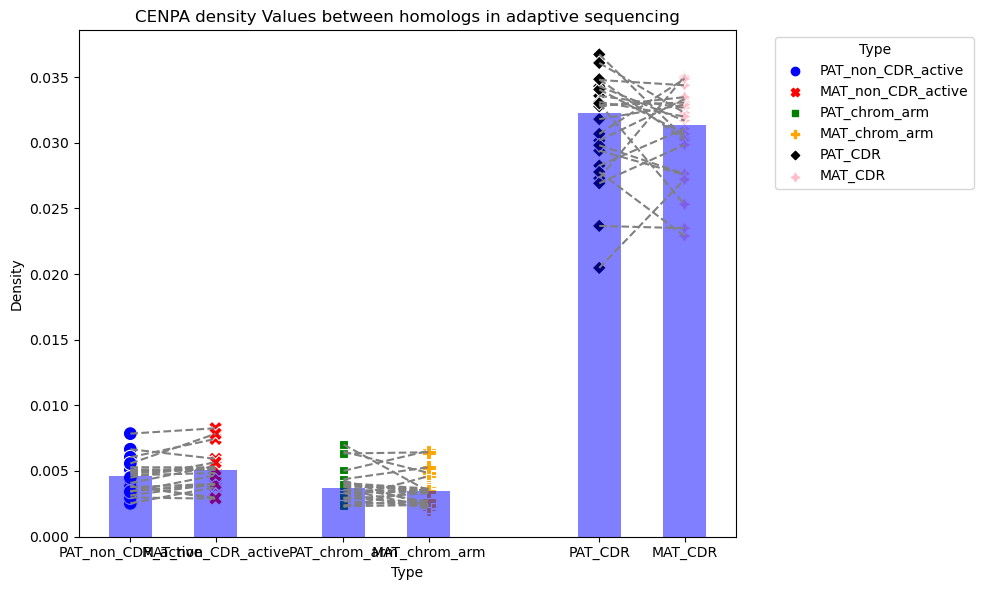

In [7]:

# Function to process the data and create a DataFrame for strip plot
def process_df(df, type_label,type_pos):
    strip_plot_df = pd.DataFrame(columns=['Chromosome', 'Density', 'Type','Type_Pos'])
    new_rows = []
    for chrom in chromosomes:
        maternal_col = f'{chrom}_MATERNAL'
        paternal_col = f'{chrom}_PATERNAL'

        MAT_indices = df.index[df['Chromosome'] == maternal_col].tolist()
        PAT_indices = df.index[df['Chromosome'] == paternal_col].tolist()

        PAT_values = df.loc[PAT_indices]['Density'].tolist()
        MAT_values = df.loc[MAT_indices]['Density'].tolist()

        PAT_density_avg = np.mean(PAT_values) if PAT_values else 0
        MAT_density_avg = np.mean(MAT_values) if MAT_values else 0

        # Append new row data for paternal and maternal columns to the list
        new_rows.append({'Chromosome': paternal_col,
                         'Density': PAT_density_avg,
                         'Type': f'PAT_{type_label}',
                         'Type_Pos': type_pos})
        
        new_rows.append({'Chromosome': maternal_col,
                         'Density': MAT_density_avg,
                         'Type': f'MAT_{type_label}',
                         'Type_Pos': type_pos + 0.2})

    # Create a DataFrame from the list of new rows and concatenate with the existing DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    strip_plot_df = pd.concat([strip_plot_df, new_rows_df], ignore_index=True)

    return strip_plot_df

# Assuming 'chromosomes' and the DataFrames are already defined

strip_plot_non_active_df = process_df(CENPA_non_active_A_combined_df, 'non_CDR_active',0.5)
strip_plot_CDR_df = process_df(CENPA_CDR_A_combined_df, 'CDR', 1.6)
strip_plot_chrom_arm_df = process_df(CENPA_chrom_arm_A_combined_df, 'chrom_arm', 1.0)

# Concatenate the processed DataFrames
combined_df = pd.concat([strip_plot_non_active_df, 
                         strip_plot_chrom_arm_df,
                         strip_plot_CDR_df], ignore_index=True)

# Update the x-coordinates mapping for plotting
type_pos_map = {'PAT_non_CDR_active': 0.5,
                'MAT_non_CDR_active': 0.7,
               'PAT_chrom_arm':1.0,
               'MAT_chrom_arm':1.2,
                'PAT_CDR': 1.6,
                'MAT_CDR': 1.8}
#combined_df['Type_Pos'] = combined_df['Type'].map(type_pos_map)
print (combined_df)

medians_dict = {type_label: combined_df[combined_df['Type'] == type_label]['Density'].median() for type_label in type_pos_map.keys()}

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Type_Pos', y='Density', hue='Type', style='Type', data=combined_df, s=100, palette=['blue', 'red', 'green', 'orange','black','pink'])

# Drawing lines between the points
for chrom in chromosomes:
    for type_label in ['non_CDR_active', 'CDR','chrom_arm']:
        pat_row = combined_df[(combined_df['Chromosome'] == f'{chrom}_PATERNAL') & (combined_df['Type'] == f'PAT_{type_label}')]
        mat_row = combined_df[(combined_df['Chromosome'] == f'{chrom}_MATERNAL') & (combined_df['Type'] == f'MAT_{type_label}')]
        if not pat_row.empty and not mat_row.empty:
            plt.plot([type_pos_map[f'PAT_{type_label}'], type_pos_map[f'MAT_{type_label}']],
                     [pat_row['Density'].values[0], mat_row['Density'].values[0]],
                     color='gray', linestyle='--')

for type_label, median in medians_dict.items():
    plt.bar(type_pos_map[type_label], median, width=0.1, color='blue', alpha=0.5)

            
# Customizing the plot
plt.xticks(list(type_pos_map.values()), list(type_pos_map.keys()))
plt.title('CENPA density Values between homologs in adaptive sequencing')
plt.xlabel('Type')
plt.ylabel('Density')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


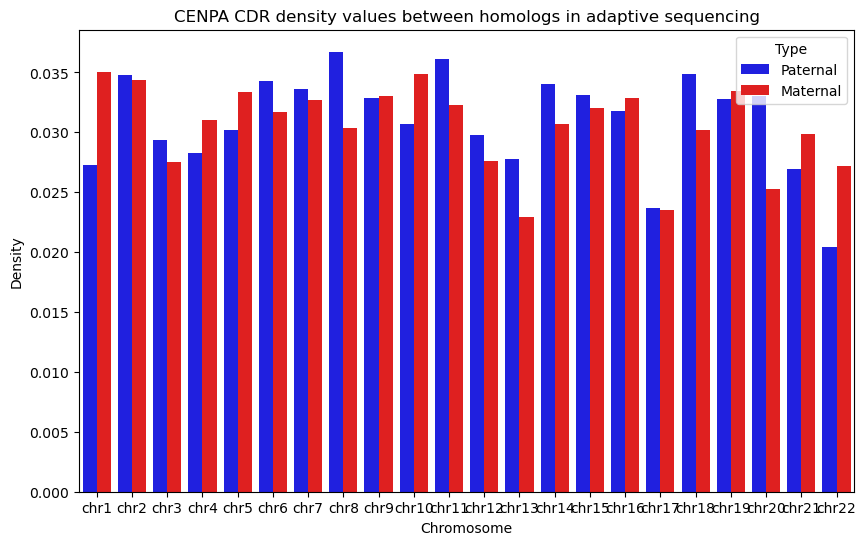

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'CENPA_CDR_A_combined_df' is already defined and contains 'Chromosome', 'Density', and we already have 'Chromosome_Label'
# Add a new column to indicate if the data is 'Paternal' or 'Maternal'
CENPA_CDR_A_combined_df['Chromosome_Label'] = CENPA_CDR_A_combined_df['Chromosome'].str.replace('_PATERNAL', '').str.replace('_MATERNAL', '')

CENPA_CDR_A_combined_df['Type'] = CENPA_CDR_A_combined_df['Chromosome'].apply(lambda x: 'Paternal' if 'PATERNAL' in x else 'Maternal')

# Set the color palette
palette = {'Paternal': 'blue', 'Maternal': 'red'}

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Chromosome_Label', y='Density', hue='Type', data=CENPA_CDR_A_combined_df, palette=palette, errorbar=None)

plt.title('CENPA CDR density values between homologs in adaptive sequencing')
plt.xlabel('Chromosome')
plt.ylabel('Density')

plt.show()
